# Jeu de données avec des catégories

Le jeu de données [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) ne contient presque que des catégories. Ce notebook explore différentes moyens de les traiter.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
import fiona

## données

In [4]:
from papierstat.datasets import load_adult_dataset
train, test = load_adult_dataset(url="copy")
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
label = '<=50K'
set(train[label])

{'<=50K', '>50K'}

In [6]:
set(test[label])

{'<=50K', '>50K'}

In [7]:
import numpy
import pandas
X_train = train.drop(label, axis=1)
y_train = train[label] == '>50K'
y_train = pandas.Series(numpy.array([1.0 if y else 0.0 for y in y_train]))
X_test = test.drop(label, axis=1)
y_test = test[label] == '>50K'
y_test = pandas.Series(numpy.array([1.0 if y else 0.0 for y in y_test]))

In [8]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
<=50K             object
dtype: object

La variable *fnlwgt* représente une forme de pondération : le nombre d'individus que chaque observation représente. Elle ne doit pas servir à la prédiction, comme pondération qu'on ignorera : cette pondération n'est pas liée aux données mais à l'échantillon et elle est impossible à construire. Il faut s'en passer.

In [9]:
X_train = X_train.drop(['fnlwgt'], axis=1).copy()
X_test = X_test.drop(['fnlwgt'], axis=1).copy()

## catégories

On garde la liste des variables catégorielles.

In [10]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

La fonction [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) est pratique mais problématique si les modalités de la base d'apprentissage et la base de test sont différentes, ce qui est fréquemment le cas pour les catégories peu fréquentes. Il faudrait regrouper les deux bases, l'appliquer puis sépareer à nouveau. Trop long. On veut utiliser [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) mais ce n'est pas très pratique parce que [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) n'accepte que les colonnes entières et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) et peut traiter qu'une colonne à la fois.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pipe = make_pipeline(LabelEncoder(), OneHotEncoder())
try:
    pipe.fit(X_train[cat_col[0]], y_train)
except Exception as e:
    print(e)

fit_transform() takes 2 positional arguments but 3 were given


On utilise [OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/) du module [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/).

In [12]:
from category_encoders import OneHotEncoder
ce = OneHotEncoder(cols=cat_col, handle_missing='value',
                   drop_invariant=False, handle_unknown='value')
X_train_cat = ce.fit_transform(X_train)
X_train_cat.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,...,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,native_country_42
0,39,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C'est assez compliqué à lire. On renomme les colonnes avec les noms des catégories originaux. Il y a probablement mieux mais ce code fonctionne.

In [13]:
def rename_columns(df, ce):
    rev_mapping = {r['col']: r['mapping'] for r in ce.category_mapping}
    cols = []
    for c in df.columns:
        if '_' not in c:
            cols.append(c)
            continue
        spl = c.split('_')
        col = "_".join(spl[:-1])
        try:
            nb = int(spl[-1])    
            mapping  = rev_mapping[col]        
            cols.append(str(col) + "__" + str(mapping.index[nb]))
        except ValueError:
            cols.append(c)
    df.columns = cols + list(df.columns)[len(cols):]

rename_columns(X_train_cat, ce)
X_train_cat.head()

,age,workclass__Self-emp-not-inc,workclass__Private,workclass__Federal-gov,workclass__Local-gov,workclass__?,workclass__Self-emp-inc,workclass__Without-pay,workclass__Never-worked,workclass__nan,...,native_country__Scotland,native_country__Trinadad&Tobago,native_country__Greece,native_country__Nicaragua,native_country__Vietnam,native_country__Hong,native_country__Ireland,native_country__Hungary,native_country__Holand-Netherlands,native_country__nan
0,39,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C'est plus clair. Une dernière remarque sur le paramètre *handle_missing* et *handle_unknown*. Le premier définit la façon de gérer les valeurs manquantes, le premier la façon dont le modèle doit gérer les catégories nouvelles, c'est-à-dire les catégories non vues dans la base d'apprentissage.

## premier jet

On construit un [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [14]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(
            OneHotEncoder(cols=cat_col, handle_missing='value',
                          drop_invariant=False, handle_unknown='value'), 
            LogisticRegression())
pipe.fit(X_train, y_train)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'sex', 'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_sta

In [15]:
pipe.score(X_test, y_test)

0.8426386585590566

On essaye avec une [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [16]:
from sklearn.ensemble import RandomForestClassifier
pipe2 = make_pipeline(ce, RandomForestClassifier(n_estimators=100))
pipe2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'sex', 'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                 

In [17]:
pipe2.score(X_test, y_test)

0.8448498249493275

In [18]:
pipe2.steps[-1][-1].feature_importances_[:5]

array([0.22779679, 0.00529596, 0.00965327, 0.01187745, 0.00584904])

On regarde l'[importance des features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [19]:
import pandas
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe2.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
df.head()

,importance
name,
age,0.227797
hours_per_week,0.113923
capital_gain,0.110967
marital_status__Divorced,0.067712
education_num,0.064527


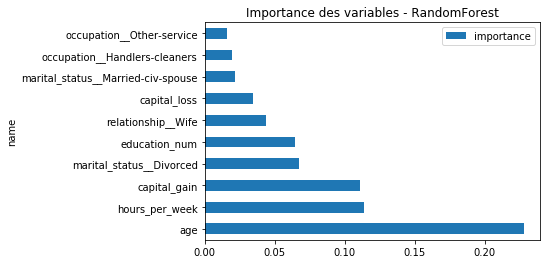

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - RandomForest');

On compare avec [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html). L'âge semble la variable plus importante. Cela dit, si ce graphique donne quelques pistes, ce n'est pas la vérité car les variables peuvent être corrélées. Deux variables corrélées sont interchangeables.

In [21]:
from xgboost import XGBClassifier
pipe3 = make_pipeline(ce, XGBClassifier())
pipe3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'sex', 'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', ra

In [22]:
pipe3.score(X_test, y_test)

0.869172655242307

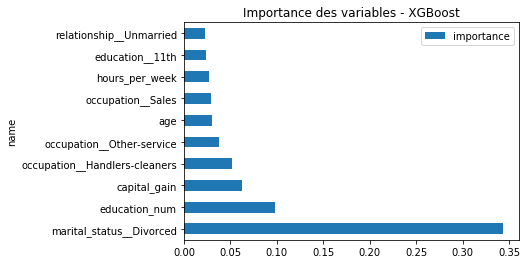

In [23]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe3.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - XGBoost');

On retrouve presque les mêmes variables mais pas dans le même ordre. On essaye un dernier module [catboost](https://tech.yandex.com/catboost/).

In [24]:
from catboost import CatBoostClassifier
pipe4 = make_pipeline(ce, CatBoostClassifier(iterations=100, verbose=False))
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'sex', 'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001E0DF767AC8>)],
         verbose=False)

In [25]:
pipe4.score(X_test, y_test)

0.0

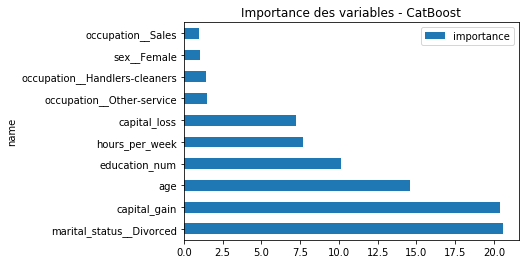

In [26]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe4.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - CatBoost');

Les modèles sont à peu près d'accord sur la performance mais pas vraiment sur l'ordre des features les plus importantes. Comme ce sont tous des random forests, même apprises différemment, on peut supposer qu'il existe des corrélations entre les variables. Des corrélations au sens du modèle donc pas nécessairement linéaires.

## Courbe ROC

In [27]:
from sklearn.metrics import roc_curve
import warnings
if len(pipe2.steps[-1][-1].classes_) != len(pipe3.steps[-1][-1].classes_):
    raise Exception("Mésentente classificatoire pipe2 {0} != pipe3 {1}".format(
                    pipe2.steps[-1][-1].classes_, pipe3.steps[-1][-1].classes_))
if len(pipe2.steps[-1][-1].classes_) != len(pipe4.steps[-1][-1].classes_):
    if not pipe4.steps[-1][-1].classes_:
        # Probably a bug (happens on circleci).
        # Assuming classes are in the same order.
        # See https://github.com/catboost/catboost/blob/master/catboost/python-package/catboost/core.py#L1994
        warnings.warn("pipe4.steps[-1][-1].classes_ is empty.")
        pipe4.steps[-1][-1]._classes = pipe2.steps[-1][-1].classes_
if len(pipe2.steps[-1][-1].classes_) != len(pipe4.steps[-1][-1].classes_):
    print("Mésentente classificatoire pipe2 {0} != pipe4 {1}".format(
                    pipe2.steps[-1][-1].classes_, pipe4.steps[-1][-1].classes_))

index2 = pipe2.steps[-1][-1].classes_[1]
index3 = pipe3.steps[-1][-1].classes_[1]
index4 = pipe4.steps[-1][-1].classes_[1]
fpr2, tpr2, th2 = roc_curve(y_test, pipe2.predict_proba(X_test)[:, 1], 
                            pos_label=index2, drop_intermediate=False)
fpr3, tpr3, th3 = roc_curve(y_test, pipe3.predict_proba(X_test)[:, 1], 
                            pos_label=index3, drop_intermediate=False)
if len(pipe4.steps[-1][-1].classes_) >= 2:
    fpr4, tpr4, th4 = roc_curve(y_test, pipe4.predict_proba(X_test)[:, 1], 
                                pos_label=index4, drop_intermediate=False)
else:
    fpr4 = None

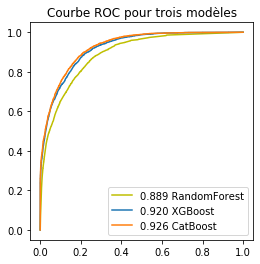

In [28]:
from sklearn.metrics import auc
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(fpr2, tpr2, label='%1.3f RandomForest' % auc(fpr2, tpr2), color='y')
ax.plot(fpr3, tpr3, label='%1.3f XGBoost' % auc(fpr3, tpr3))
if fpr4 is not None:
    ax.plot(fpr4, tpr4, label='%1.3f CatBoost' % auc(fpr4, tpr4))
ax.legend()
ax.set_title('Courbe ROC pour trois modèles');

## GridSearch

On cherche à optimiser les hyperparamètres sur la base d'apprentissage. On vérifie d'abord que les données sont bien identiquement distribuées. La validation croisée considère des parties contigües de la base de données. Il arrive que les données ne soient pas tout-à-fait homogènes et qu'il faille les mélanger. On compare les performances avant et après mélange pour vérifier que l'ordre des données n'a pas d'incidence.

In [29]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe2, X_train, y_train, cv=5)

array([0.84707508, 0.84152334, 0.84259828, 0.85288698, 0.84766585])

In [30]:
from pandas_streaming.df import dataframe_shuffle
from numpy.random import permutation
index = permutation(X_train.index)
X_train_shuffled = X_train.iloc[index, :]
y_train_shuffled = y_train[index]
cross_val_score(pipe2, X_train_shuffled, y_train_shuffled, cv=5)

array([0.84277599, 0.84797297, 0.84659091, 0.84981572, 0.85089066])

L'ordre de la base n'a pas d'incidence.

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {'randomforestclassifier__n_estimators':[10, 20, 50],
              'randomforestclassifier__min_samples_leaf': [2, 10]}
cvgrid = GridSearchCV(estimator=pipe2, param_grid=param_grid, verbose=2)
cvgrid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   1.2s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   1.2s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   1.2s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   1.2s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   1.2s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   1.6s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassif

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   58.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=['workclass',
                                                            'education',
                                                            'marital_status',
                                                            'occupation',
                                                            'relationship',
                                                            'race', 'sex',
                                                            'native_country'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                             

In [32]:
import pandas
df = pandas.DataFrame(cvgrid.cv_results_['params'])
df['mean_fit_time'] = cvgrid.cv_results_['mean_fit_time']
df['mean_test_score'] = cvgrid.cv_results_['mean_test_score']
df.sort_values('mean_test_score')

,randomforestclassifier__min_samples_leaf,randomforestclassifier__n_estimators,mean_fit_time,mean_test_score
3,10,10,1.069937,0.857437
4,10,20,1.351183,0.858635
5,10,50,2.862142,0.859034
0,2,10,1.094900,0.861092
1,2,20,1.456303,0.863641
2,2,50,2.944120,0.863764


Il faudrait continuer à explorer les hyperparamètres et confirmer sur la base de test. A priori, cela marche mieux avec plus d'arbres.

## Features polynômiales

On essaye même si cela a peu de chance d'aboutir compte tenu des variables, principalement catégorielles, et du fait qu'on utilise une forêt aléatoire.

In [33]:
from sklearn.preprocessing import PolynomialFeatures
pipe5 = make_pipeline(ce, PolynomialFeatures(), RandomForestClassifier())
pipe5.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'sex', 'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    int...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease

In [34]:
pipe5.score(X_test, y_test)

0.8463853571647934

Ca n'améliore pas.

## Interprétation

On souhaite en savoir plus sur les variables.

In [35]:
conc = pandas.concat([X_train_cat, pandas.Series(y_train)], axis=1)
conc.head()

,age,workclass__Self-emp-not-inc,workclass__Private,workclass__Federal-gov,workclass__Local-gov,workclass__?,workclass__Self-emp-inc,workclass__Without-pay,workclass__Never-worked,workclass__nan,...,native_country__Trinadad&Tobago,native_country__Greece,native_country__Nicaragua,native_country__Vietnam,native_country__Hong,native_country__Ireland,native_country__Hungary,native_country__Holand-Netherlands,native_country__nan,0
0,39,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,38,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,53,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,28,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [36]:
corr = conc.corr()

c:\python372_x64\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
c:\python372_x64\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


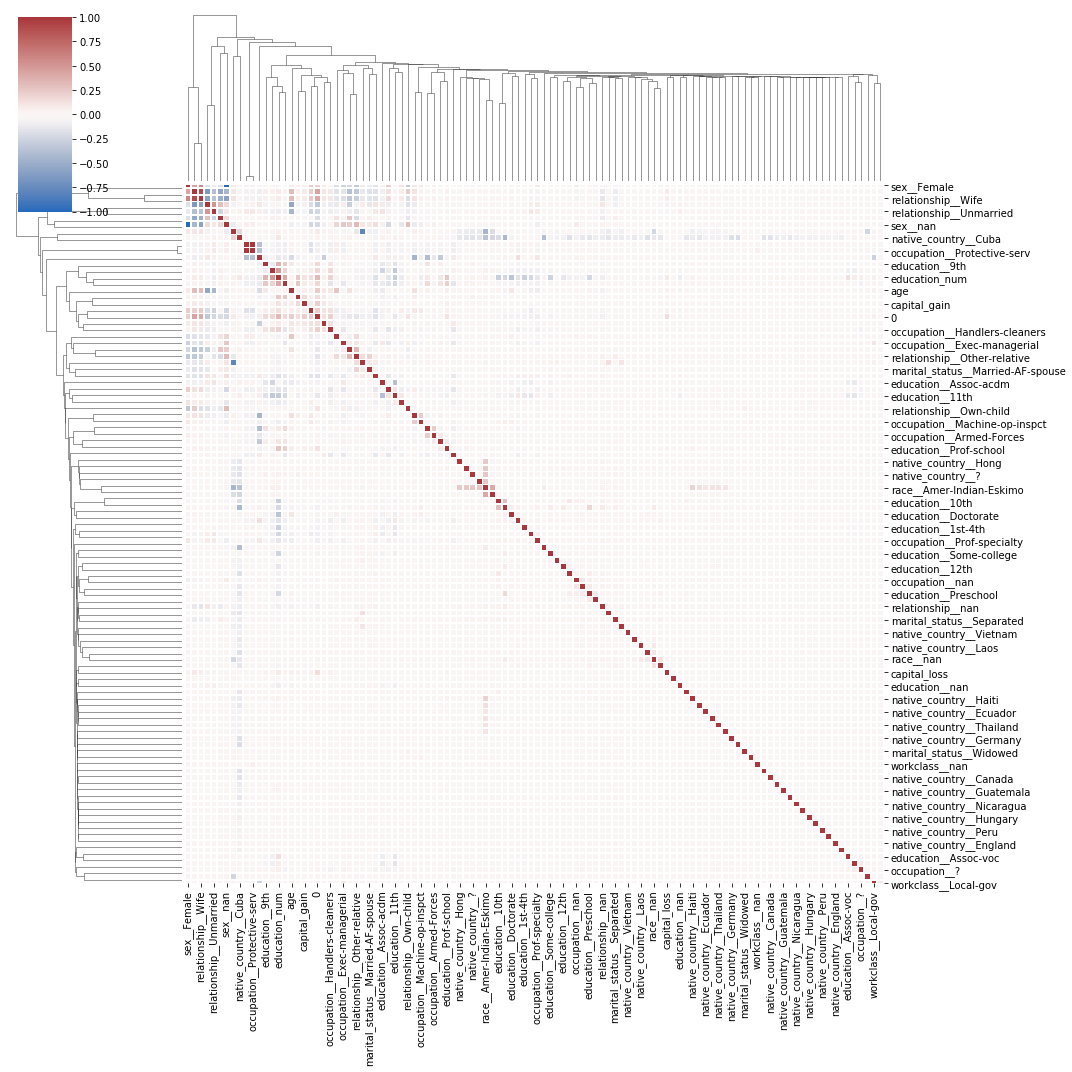

In [37]:
from seaborn import clustermap

clustermap(corr, center=0, cmap="vlag", linewidths=.75, figsize=(15, 15));

Ce n'est pas facile à voir. Il faudrait essayer avec [bokeh](https://bokeh.pydata.org/en/latest/docs/gallery/les_mis.html) ou essayer de procéder autrement.

## ACM

Ce qui suit n'est pas tout-à-fait une [ACM](https://fr.wikipedia.org/wiki/Analyse_des_correspondances_multiples) mais cela s'en inspire. On considère les variables comme des observations et on les projette sur des plans définis par les axes d'une [ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales). On normalise également car on mélange variables continues et variables binaires d'ordre de grandeur différents. Les calculs sont plus précis lorsque les matrices ont des coefficients de même ordre. Le dernier exercice de cet examen [Programmation ENSAE 2006](http://www.xavierdupre.fr/site2013/enseignements/tdnote/ecrit_2006.pdf) achèvera de vous convaincre.

In [38]:
from sklearn.preprocessing import StandardScaler
import pandas
rows_cat = pandas.DataFrame(StandardScaler().fit_transform(X_train_cat))
rows_cat.columns = X_train_cat.columns
rows_cat = rows_cat.T
rows_cat.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,32551,32552,32553,32554,32555,32556,32557,32558,32559,32560
age,0.030671,0.837109,-0.042642,1.057047,-0.775768,-0.115955,0.763796,0.983734,-0.555830,0.250608,...,-0.482518,0.323921,-0.482518,1.057047,-1.215643,-0.849080,0.103983,1.423610,-1.215643,0.983734
workclass__Self-emp-not-inc,4.907700,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,...,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761


In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(rows_cat)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
import pandas
tr = pandas.DataFrame(pca.transform(rows_cat))
tr.columns = ['axe1', 'axe2', 'axe3']
tr.index = rows_cat.index
tr.sort_values('axe1').head(n=2)

,axe1,axe2,axe3
sex__nan,-129.499567,60.907917,29.421935
marital_status__Married-civ-spouse,-106.135296,-11.383937,-54.355587


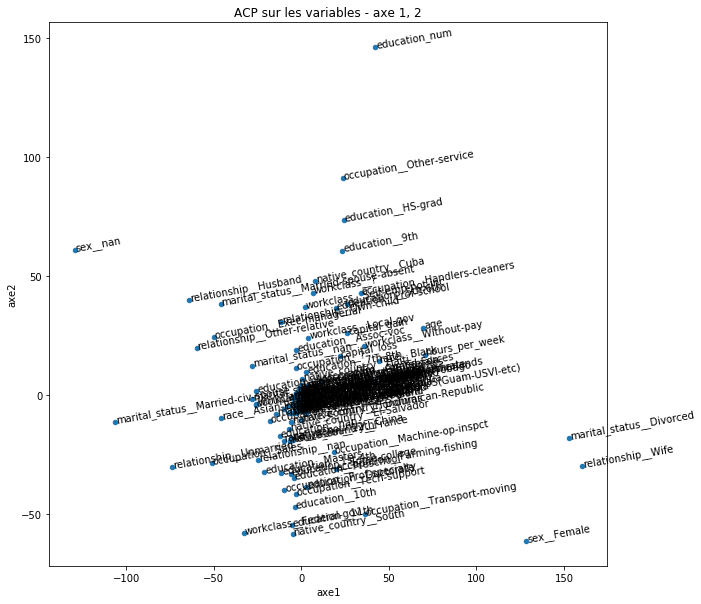

In [41]:
ax = tr.plot(x='axe1', y='axe2', kind='scatter', figsize=(10, 10))
for t, (x, y, z) in tr.iterrows():
    ax.text(x, y, t, fontsize=10, rotation=10)
ax.set_title("ACP sur les variables - axe 1, 2");

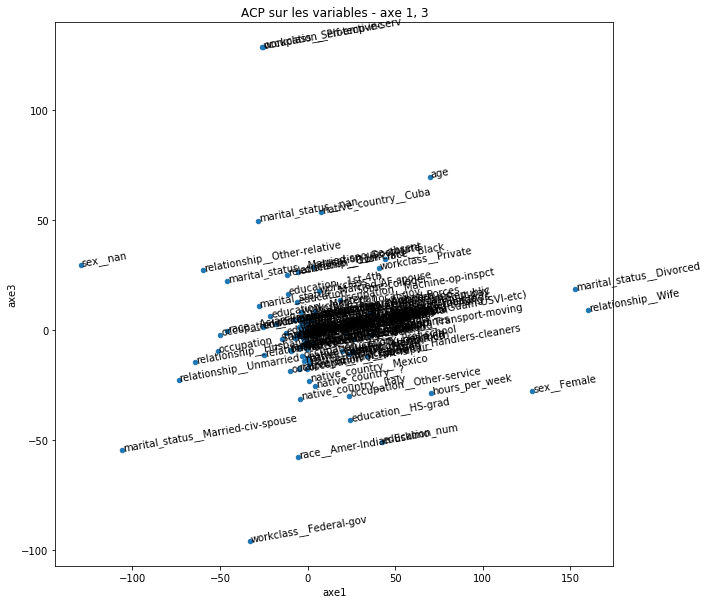

In [42]:
ax = tr.plot(x='axe1', y='axe3', kind='scatter', figsize=(10, 10))
for t, (x, y, z) in tr.iterrows():
    ax.text(x, z, t, fontsize=10, rotation=10)
ax.set_title("ACP sur les variables - axe 1, 3");

On voit quelques variables à supprimer car très corrélées comme la relation ou la situation maritale. On voit aussi que les deux genres homme/femme sont opposés. On voit aussi que certaines catégories sont très proches comme Prof, Masters ou diplômés. Il est probable que le modèle de prédiction ne pâtisse pas du regroupement de ces trois catégories. On utilise [bokeh](https://bokeh.pydata.org/en/latest/) pour pouvoir zoomer.

In [43]:
import bokeh, bokeh.io as bio
bio.output_notebook()

Loading BokehJS ...

In [44]:
from bokeh.plotting import figure, show
p = figure(title="ACP sur les variables - axe 1, 2")
p.circle(tr["axe1"], tr["axe2"])
p.text(tr["axe1"], tr["axe2"], tr.index,
       text_font_size="8pt", text_baseline="middle", angle=0.1)
show(p)

## Analyse d'erreur

On recherche les erreurs les plus flagrantes, celles dont le score est élevé.

In [45]:
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)
pred2 = pipe2.predict(X_test)
proba2 = pipe2.predict_proba(X_test)
pred3 = pipe3.predict(X_test)
proba3 = pipe3.predict_proba(X_test)
pred4 = pipe4.predict(X_test)
proba4 = pipe4.predict_proba(X_test)

In [46]:
data = pandas.concat([
            pandas.DataFrame(y_test.astype(float).values, columns=['y_test']),
            pandas.DataFrame(pred, columns=['pred1']),
            pandas.DataFrame(proba[:,1], columns=['P1(>=50K)']),
            pandas.DataFrame(pred2, columns=['pred2']),
            pandas.DataFrame(proba2[:,1], columns=['P2(>=50K)']),
            pandas.DataFrame(pred3, columns=['pred3']),
            pandas.DataFrame(proba3[:,1], columns=['P3(>=50K)']),
            pandas.DataFrame(pred4, columns=['pred4']),
            pandas.DataFrame(proba4[:,1], columns=['P4(>=50K)']),
            X_test,
            ], axis=1)
data.head()

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.0,0.0,0.010831,0.0,0.000000,0.0,0.007642,0.0,0.000384,25,...,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,0.0,0.0,0.179896,0.0,0.030000,0.0,0.203497,0.0,0.207168,38,...,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,1.0,1.0,0.526712,1.0,0.526667,0.0,0.277167,0.0,0.471523,28,...,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,1.0,1.0,0.789027,1.0,0.930000,1.0,0.984138,1.0,0.987516,44,...,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,0.0,0.0,0.009680,0.0,0.000000,0.0,0.002210,0.0,0.000151,18,...,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [47]:
data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=False).head().T

,3605,2926,13783,2247,13128
y_test,0,0,0,0,0
pred1,1,1,1,1,1
P1(>=50K),1,0.793878,0.764859,0.788413,0.832539
pred2,1,1,1,1,1
P2(>=50K),0.74,0.74,0.937333,0.94,0.65
pred3,1,1,1,1,1
P3(>=50K),0.972606,0.900088,0.933867,0.796695,0.913922
pred4,1,1,1,1,1
P4(>=50K),0.998917,0.989239,0.980988,0.944513,0.931411
age,36,65,51,55,48


Tous les modèles font l'erreur sur ces cinq exemples. Le modèle a toutes les raisons de décider que les personnes gagnent plus de 50k par an, beaucoup d'études, plutôt âge ou travaillant beaucoup.

In [48]:
wrong_study = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head(n=3).T
wrong_study

,10408,5953,3059
y_test,1,1,1
pred1,0,0,0
P1(>=50K),0.0146811,0.00972505,0.0145646
pred2,0,0,0
P2(>=50K),0,0,0
pred3,0,0,0
P3(>=50K),0.00288558,0.00299048,0.00561586
pred4,0,0,0
P4(>=50K),0.000149386,0.000395875,0.000863302
age,22,20,22


Ceux-ci sont probablement étudiants et déjà aisés. Il faudrait avoir quelques informations sur les parents pour confirmer. On recherche les plus proches voisins dans la base pour voir ce que le modèle répond. Il faut néanmoins appliquer cela sur la base une fois les catégories transformées.

In [49]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors()
knn.fit(X_train_cat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [50]:
X_test_cat = pipe2.steps[0][-1].transform(X_test)
X_test_cat.columns = X_train_cat.columns

In [51]:
wrong = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head()
wrong.head(n=2)

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
10408,1.0,0.0,0.014681,0.0,0.0,0.0,0.002886,0.0,0.000149,22,...,10,Never-married,?,Own-child,White,Male,0,0,15,?
5953,1.0,0.0,0.009725,0.0,0.0,0.0,0.002990,0.0,0.000396,20,...,8,Never-married,Other-service,Own-child,Black,Male,0,0,35,United-States


In [52]:
wrong_cat = X_test_cat.iloc[wrong.index, :]
wrong_cat.head()

,age,workclass__Self-emp-not-inc,workclass__Private,workclass__Federal-gov,workclass__Local-gov,workclass__?,workclass__Self-emp-inc,workclass__Without-pay,workclass__Never-worked,workclass__nan,...,native_country__Scotland,native_country__Trinadad&Tobago,native_country__Greece,native_country__Nicaragua,native_country__Vietnam,native_country__Hong,native_country__Ireland,native_country__Hungary,native_country__Holand-Netherlands,native_country__nan
10408,22,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5953,20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3059,22,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11821,24,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12808,67,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
dist, index = knn.kneighbors(wrong_cat)
dist

array([[2.        , 2.        , 2.23606798, 2.44948974, 2.44948974],
       [1.41421356, 1.41421356, 2.23606798, 2.23606798, 2.23606798],
       [1.        , 1.41421356, 1.41421356, 1.73205081, 1.73205081],
       [1.41421356, 1.73205081, 1.73205081, 1.73205081, 2.        ],
       [2.64575131, 3.31662479, 3.46410162, 3.46410162, 3.74165739]])

In [54]:
index

array([[18056, 18362,  8757, 13177,   314],
       [24878, 30060, 27902,  8008, 23771],
       [  920, 31176,  5206,  7415, 15308],
       [17303, 18592,  2019, 20325,  7542],
       [  346, 14421,  8214, 11050, 18902]], dtype=int64)

In [55]:
train_nn = pandas.concat([X_train, y_train], axis=1).iloc[[24878, 18056, 920], :].T
train_nn.columns = ['TR-' + str(_) for _ in train_nn.columns]
train_nn

,TR-24878,TR-18056,TR-920
age,20,21,23
workclass,Private,?,Private
education,12th,Some-college,Some-college
education_num,8,10,10
marital_status,Never-married,Never-married,Never-married
occupation,Other-service,?,Sales
relationship,Own-child,Own-child,Not-in-family
race,White,White,White
sex,Male,Male,Male
capital_gain,0,0,0


Il faut comparer la première colonne avec la quatrième, la seconde avec la ciinquième et la troisème avec la sixième. Ces exemples sont voisins. On voit que les exemples sont très proches. Il n'y a qu'une seule valeur qui change à chaque fois et il est difficile d'expliquer les erreurs.

In [56]:
pandas.concat([train_nn, wrong_study], axis=1, sort=True)

,TR-24878,TR-18056,TR-920,10408,5953,3059
age,20,21,23,22,20,22
capital_gain,0,0,0,0,0,0
capital_loss,0,0,0,0,0,0
education,12th,Some-college,Some-college,Some-college,12th,Some-college
education_num,8,10,10,10,8,10
hours_per_week,35,16,25,15,35,25
marital_status,Never-married,Never-married,Never-married,Never-married,Never-married,Never-married
native_country,United-States,United-States,United-States,?,United-States,United-States
occupation,Other-service,?,Sales,?,Other-service,Sales
race,White,White,White,White,Black,White


## Ethique

Le modèle qu'on a appris est-il éthique ? Il n'y a pas de réponse simples à ce problème car il est difficile de transcrire mathématiquement le caractère éthique d'un modèle. Dans le cas présent, admettons que l'on souhaite vérifier que le modèle ne retourne pas une réponse biaisée en fonction du genre. Une première idée consiste à enlever la variable pour être sûr sur le modèle n'en tienne pas compte mais cela ne garantit que la variable genre n'est une variable corrélée aux autres. Et la corrélation implique ici au sens du modèle ce qui a un sens plus fort si le modèle n'est pas linéaire. On aura tout-à-faire enlevé la variable genre si elle ne peut être prédite à partir des autres.

In [57]:
X_train_sex = train.drop([label, 'sex'], axis=1)
y_train_sex = train['sex'] == 'Male'
X_test_sex = test.drop([label, 'sex'], axis=1)
y_test_sex = test['sex'] == 'Male'

In [58]:
ce_sex = OneHotEncoder(cols=[_ for _ in cat_col if _ != 'sex'], 
                       handle_missing='value', drop_invariant=False,
                       handle_unknown='value')
model_sex = make_pipeline(ce_sex, RandomForestClassifier(n_estimators=100))
model_sex.fit(X_train_sex, y_train_sex)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['workclass', 'education', 'marital_status',
                                     'occupation', 'relationship', 'race',
                                     'native_country'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        

In [59]:
model_sex.score(X_test_sex, y_test_sex)

0.8368650574289048

Il est possible de prédire le genre en fonction des autres variables à 83% près. Ce n'est pas en enlevant la variable qu'on peut empêcher le modèle d'être biaisé par rapport à cette information. Il n'est pas évident de retirer toute influence de ce paramètre. On peut choisir de la garder en supposant que le modèle la choisira plutôt qu'une autre pour prédire si elle s'avère pertinente. Dans ce cas, on pourrait comparer combien de fois le modèle change de prédiction si on inverse la variable *sex*. On rappelle la performance du modèle.

In [60]:
pipe2.score(X_test, y_test)

0.8448498249493275

On remplace la variable *sex* par la prédiction de l'autre modèle.

In [61]:
X_test_modified = X_test.copy()
X_test_modified['sex'] = model_sex.predict(X_test_sex)
X_test_modified['sex'] = X_test_modified['sex'].apply(lambda x: 'Male' if x else 'Female')

In [62]:
pipe2.score(X_test_modified, y_test)

0.843928505620048

Quasiment aucun changement. Inversons la colonne maintenant.

In [63]:
X_test_inv = X_test.copy()
X_test_inv['sex'] = X_test_inv['sex'].apply(lambda x: 'Female' if x == 'Male' else 'Male')

In [64]:
pipe2.score(X_test_inv, y_test)

0.8505005835022419

Encore mieux. Regardons les différences maintenant.

In [65]:
diff1 = X_test['sex'] != X_test_inv['sex']
diff2 = pipe2.predict(X_test) != pipe2.predict(X_test_inv)
diff2.sum(), diff1.sum(), diff2.sum() / diff1.sum()

(1024, 16281, 0.06289539954548247)

La prédiction change dans 5% des cas. On est sûr que pour ces observations et ce modèle, le genre a un impact, cela ne veut rien dire pour les autres. Regardons les cinq premières.

In [66]:
look = X_test.copy()
look['y'] = y_test
look['prediction_sex'] = model_sex.predict(X_test_sex)
look[diff2].head().T

,2,14,17,19,28
age,28,48,43,40,54
workclass,Local-gov,Private,Private,Private,Private
education,Assoc-acdm,HS-grad,HS-grad,Doctorate,HS-grad
education_num,12,9,9,16,9
marital_status,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse
occupation,Protective-serv,Machine-op-inspct,Adm-clerical,Prof-specialty,Craft-repair
relationship,Husband,Husband,Wife,Husband,Husband
race,White,White,White,Asian-Pac-Islander,White
sex,Male,Male,Female,Male,Male
capital_gain,0,3103,0,0,0


Il existe visible quelques observations à vérifier où la relation *relationship* et le genre *sex* semble être en contradiction ou plutôt ne pas prendre en compte tous les types de relations possibles.

In [67]:
X_train[['sex', 'relationship', 'age']].groupby(['sex', 'relationship'], as_index=False)\
        .count().pivot('sex', 'relationship', 'age')

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
sex,,,,,,
Female,1,3875,430,2245,2654,1566
Male,13192,4430,551,2823,792,2


Pas de conclusion à ce stade. Il faut poursuivre l'exploration [Machine Learning éthique](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/td_2a_mlplus.html#machine-learning-ethique).

## Sélection des variables

Il n'y a pas de méthode optimale pour sélectionner les variables. Il existe différentes options comme celles proposées par [scikit-learn/feature_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). Certaines partent des features brutes, d'autres utilisent le modèle qui doit être appris. Mais ce n'est pas toujours évident de faire marcher ces méthodes sur n'importe quel modèle.

In [68]:
from sklearn.feature_selection import RFE
try:
    model = RFE(pipe2)
    model.fit(X_train, y_train)
except Exception as e:
    print(e)

could not convert string to float: 'State-gov'


Dans notre cas, on retire les variables une à une en fonction de l'indicateur ``feature_importance`` ce qui n'est pas facile car les variables sont des modalités. Il faut en faire la somme...

In [69]:
def grouped_feature_importance(model, datas, cat_col):
    ce = model.steps[0][-1]
    data_cat = ce.fit_transform(datas)    
    rename_columns(data_cat, ce)
    df = pandas.DataFrame(dict(name=data_cat.columns, 
                               importance=model.steps[-1][-1].feature_importances_))
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    df['raw_var'] = df['name'].apply(lambda x: x.split('__')[0])
    gr = df.groupby('raw_var').sum().sort_values('importance', ascending=True).reset_index(drop=False).copy()
    return gr

fi_global = grouped_feature_importance(pipe2, X_train, cat_col)
fi_global

,raw_var,importance
0,race,0.018372
1,sex,0.019006
2,native_country,0.028188
3,capital_loss,0.034305
4,workclass,0.047340
5,education,0.059821
6,education_num,0.064527
7,relationship,0.083855
8,occupation,0.091443
9,marital_status,0.100458


On fait une boucle.

In [70]:
kept = list(fi_global.raw_var)
res = []
last_removed = None
while len(kept) > 0:
    cat_col_red = set()
    for col in kept:
        if "__" in col:
            col = "__".join(col.split('__')[:-1])
        cat_col_red.add(col)
    cat_col_red = list(cat_col_red)
    X_train_reduced = X_train[cat_col_red]
    X_test_reduced = X_test[cat_col_red]    
    ce = OneHotEncoder(cols=cat_col_red, handle_missing='value',
                       drop_invariant=False, handle_unknown='value')    
    model = make_pipeline(ce, RandomForestClassifier(n_estimators=5))
    model.fit(X_train_reduced, y_train)
    score = model.score(X_test_reduced, y_test)
    fi = grouped_feature_importance(model, X_train_reduced, cat_col_red)
    r = dict(score=score, features=kept.copy(), nb=len(kept), model=model,
             removed=last_removed, next_remove=fi.iloc[0,0], score_remove=fi.iloc[0,1])
    print(r['nb'], r['score'], last_removed, list(fi.iloc[0,:]), X_train_reduced.shape)
    last_removed = fi.iloc[0,0]
    kept = [_ for _ in kept if _ != last_removed]
    res.append(r)

13 0.8345310484613967 None ['race', 0.017876461431527595] (32561, 13)
12 0.8328112523800749 race ['native_country', 0.030328521242080998] (32561, 12)
11 0.8377863767581843 native_country ['sex', 0.020085260379222935] (32561, 11)
10 0.8366193722744303 sex ['capital_loss', 0.04176572757064676] (32561, 10)
9 0.8286960260426264 capital_loss ['workclass', 0.051745962436835796] (32561, 9)
8 0.8289417111971009 workclass ['education', 0.06708986825516294] (32561, 8)
7 0.8292488176401941 education ['marital_status', 0.10470565098684484] (32561, 7)
6 0.8299858731036177 marital_status ['education_num', 0.12482378792123464] (32561, 6)
5 0.8271604938271605 education_num ['capital_gain', 0.15606710618140648] (32561, 5)
4 0.8043731957496468 capital_gain ['hours_per_week', 0.1952915897722717] (32561, 4)
3 0.8129721761562557 hours_per_week ['age', 0.2703491413657654] (32561, 3)
2 0.8207726798108225 age ['occupation', 0.3492816128792312] (32561, 2)
1 0.7637737239727289 occupation ['relationship', 0.9999

Il faut se rappeler qu'un classifieur constant retournerait environ 76% de bonne classification.

In [71]:
1 - y_test.sum() / len(y_test)

0.7637737239727289